# <font color ='pickle'>**Lecture Introduction to Convolution Neural Networks**

Till now we were only using feed forward neural networks. These models consider all the pixels of an image as its input features.

Now, if we want to perform tasks like detection of a particular object, we can not consider a flatten pixel layer for the image but instead need image in its actual form.

<br>

Why not feed forward network?
- They can take input only as a linear vector and therefore does not maintain the structure of the image
- They are not shift invariant which means that we shift, rotate or scale our image, input features change drastically.
- They do not preserve visual patterns in an image as they flatten it to a linear layer of pixels
- A lot parameters are needed even for a very small image.

<br> 

For example: Consider an image of shape (128 x 128 x 3), now when we convert this to a linear vector, the size becomes approximately 50k. Now if we use a linear layer whose output should be a linear layer of size 100, we need a weight matrix of shape (50k, 1000) = 50 million trainable parameters.

This is a very large number of parameters for a comparitively small size of image.

<br>

Thus, in order to create a better image classification or detection model while maintaining the structure of the image we should take into account the image in it's actual form.

We can achieve this using convolution neural networks. Let us see what the convolution operation performs:


## <font color ='pickle'>**Convolution Operation**

Convolution refers to the mathematical combination of two functions to produce a third function. It merges two sets of information. This operation is performed in CNNs and forms the basic building block for such networks.

We perform convolution operations on images using `kernel or a filter`. The output is known as the `feature map`.




## <font color ='pickle'>**Kernel / Filter**

A filter is a matrix of numbers. We slide the filter over the image and compute the dot products which is known as the `convolution operation`.

The matrix formed by sliding the filter over the image and computing the dot product is called the 'Convolved Feature' or 'Activation Map' or the 'Feature Map'. 

If the size of image is $(x, y)$ and the size of kernel is $(m, n)$, then the size of feature map will be:

$$((x - m + 1), (y - n + 1))$$

Let us create some filters for and apply convolution operation on an image.

In [ ]:
# Import the necessary libraries
import torch
import matplotlib.pyplot as plt
import cv2 as cv 
from google.colab.patches import cv2_imshow # for image display
import torchvision.transforms as transforms
import numpy as np

In [ ]:
# Import random function
import random

# Fix seed value
SEED = 2345
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Now, we will define the function for convolution operation. Convolution operation is basically sliding the kervel on all positions of the image and computing the dot product.

For example if the image and kernel are given by:

$$\mathbf{Image}=\begin{bmatrix}
1 & 2 & 3 \\
4 & 1 & 2 \\
3 & 4 & 1 \\
\end{bmatrix},\quad
\mathbf{Kernel}=\begin{bmatrix}
1 & 2 \\
0 & 1 \\
\end{bmatrix}$$

<br>

The output will be of size: $(3-2+1, 3-2+1) = (2, 2)$

$$\mathbf{Output}=\begin{bmatrix}
6 & 10 \\
10 & 6 \\
\end{bmatrix}$$

Here if $I_{ij}$ denotes pixel in the image matrix, $k_{ij}$ denotes pixel in the kernel matrix and $O_{ij}$ denotes pixel in the feature map then:

$$O_{11} = I_{11}*k_{11} + I_{12}*k_{12} + I_{21}*k_{21} + I_{22}*k_{22}$$

$$O_{12} = I_{12}*k_{11} + I_{13}*k_{12} + I_{22}*k_{21} + I_{23}*k_{22}$$

$$O_{21} = I_{21}*k_{11} + I_{22}*k_{12} + I_{31}*k_{21} + I_{32}*k_{22}$$

$$O_{22} = I_{22}*k_{11} + I_{23}*k_{12} + I_{32}*k_{21} + I_{33}*k_{22}$$

<br>

$O_{11} = 1*1 + 2*2 + 4*0 + 1*1 = 6$

$O_{12} = 2*1 + 3*2 + 1*0 + 2*1 = 10$

$O_{21} = 4*1 + 1*2 + 3*0 + 4*1 = 10$

$O_{22} = 1*1 + 2*2 + 4*0 + 1*1 = 6$




In [ ]:
def convolution(image, kernel):
    """
    Function to perform convolution operation
    Input: image and kernel
    Output: feature map
    """
    # Find the shapes of kernel and image
    xk = kernel.shape[0]
    yk = kernel.shape[1]
    ximg = image.shape[0]
    yimg = image.shape[1]

    # Shape of Output Convolution
    xout = int(ximg - xk + 1)
    yout = int(yimg - yk + 1)

    output = torch.zeros(xout, yout)
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            output[i, j] = (image[i: i + xk, j: j + yk] * kernel).sum()
    return output

In [ ]:
# Let us create the tensors for example image and kernel
image = torch.Tensor([[1, 2, 3], [4, 1, 2], [3, 4, 1]])
filter = torch.tensor([[1, 2], [0, 1]])
print(image.shape)
print(filter.shape)
print(image)
print(filter)

torch.Size([3, 3])
torch.Size([2, 2])
tensor([[1., 2., 3.],
        [4., 1., 2.],
        [3., 4., 1.]])
tensor([[1, 2],
        [0, 1]])


In [ ]:
# Get the output feature map 
output = convolution(image, filter)

# Print the output and it's shape
print(output)
print(output.shape)

tensor([[ 6., 10.],
        [10.,  6.]])
torch.Size([2, 2])


## <font color ='pickle'>**Convolution Layers**

While creating a neural network model, we can directly use the layers available to perform the convolution operation.

### <font color ='pickle'>**2D Convolution**

torch.nn provides us with `Conv2d()` function which applies a 2D convolution over an input signal composed of several input planes.

It takes input image with shape: `(batch_size, input_channels, height, width)`.

It takes in the following parameters:

- `in_channels` : Number of channels in the input image.
- `out_channels` : Number of channels produced by the convolution.
- `kernel_size` : Size of the kernel.
- `stride` : Stride of the convolution. Default: 1.
- `padding` : Padding added to both sides of the input. Default: 0.

<font color ='pickle'>**Conv2D - Input2D**

Let us consider a 2D tensor of shape (4, 4). 

Now before applying the convolution operation we have to change it's shape to (batch_size, input_channels, height, width) format.

Here we would consider batch_size = 1, input_channels = 1, height = 4, width = 4

In [ ]:
# Create an input 2D tensor
input = torch.Tensor([[1, 2, 3, 4], [2, 4, 1, 2], [2, 3, 1, 2], [1, 4, 1, 2]])

# Reshape the tensor
input = input.reshape(1, 1, 4, 4)
input.shape

torch.Size([1, 1, 4, 4])

Now, we will define the convolution operation with input channel as 1, output channel as 1 and kernel size of (2, 2).

After convolution, we will get an output of shape:(1, 1, (4 - 2 + 1), (4 - 2 + 1)) = (1, 1, 3, 3)

In [ ]:
# Create object of Conv2d
conv = torch.nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size = (2,2))

# Get the convolved output for the input
output = conv(input)

# Print output and its shape
print(output)
print(output.shape)

tensor([[[[-1.4701, -0.7262, -2.7326],
          [-2.1861, -1.3067, -1.4311],
          [-2.5026, -0.5499, -1.4311]]]], grad_fn=<ConvolutionBackward0>)
torch.Size([1, 1, 3, 3])


In [ ]:
for name, param in  conv.named_parameters():
  print(name, param)

weight Parameter containing:
tensor([[[[-0.3751, -0.2757],
          [ 0.3818, -0.2104]]]], requires_grad=True)
bias Parameter containing:
tensor([-0.4657], requires_grad=True)


In [ ]:
print(conv.weight.shape, conv.bias.shape)

torch.Size([1, 1, 2, 2]) torch.Size([1])


The most commonly used convolution layer is `Conv2d`.

There are a lot of other convolution layers available. You can check them out [here](https://pytorch.org/docs/stable/nn.html#convolution-layers).

We can observe that the convolution operation has computed the feature map according to the definition and the shape is according to the formula. 

## <font color ='pickle'>**Intution Kernel/Filter**

In [ ]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
print(X.shape)
print(X)

torch.Size([6, 8])
tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])


In [ ]:
# Vertical Filter
K = torch.tensor([[1.0, -1.0]])
print(K.shape)

torch.Size([1, 2])


In [ ]:
Y = convolution(X, K)
print(Y)

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])


In [ ]:
print(X.T)

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])


In [ ]:
convolution(X.T, K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

## <font color ='pickle'>**Learning a Kernel**

Designing an edge detector by finite differences `[1, -1]` is neat
if we know this is precisely what we are looking for.
However, as we look at larger kernels,
and consider successive layers of convolutions,
it might be impossible to specify
precisely what each filter should be doing manually.

Now let us see whether we can learn the kernel that generated `Y` from `X`
by looking at the input--output pairs only.
We first construct a convolutional layer
and initialize its kernel as a random tensor.
Next, in each iteration, we will use the squared error
to compare `Y` with the output of the convolutional layer.
We can then calculate the gradient to update the kernel.
For the sake of simplicity,
in the following
we use the built-in class
for two-dimensional convolutional layers
and ignore the bias.


In [ ]:
# Construct a two-dimensional convolutional layer with 1 output channel and a
# kernel of shape (1, 2). For the sake of simplicity, we ignore the bias here

conv2d = torch.nn.Conv2d(1, 1, kernel_size=(1, 2), bias=False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))

for i in range(20):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # Update the kernel
    conv2d.weight.data[:] -= 3e-2 * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'batch {i+1}, loss {l.sum():.3f}')

batch 2, loss 10.500
batch 4, loss 1.804
batch 6, loss 0.320
batch 8, loss 0.061
batch 10, loss 0.013
batch 12, loss 0.003
batch 14, loss 0.001
batch 16, loss 0.000
batch 18, loss 0.000
batch 20, loss 0.000


Note that the error has dropped to a small value after 10 iterations. Now we will take a look at the kernel tensor we learned.


In [ ]:
conv2d.weight.data.reshape(1,2)

tensor([[ 1.0006, -0.9990]])

In [ ]:
conv2d.weight.data

tensor([[[[ 1.0006, -0.9990]]]])

## <font color ='pickle'>**Types of Filters**

There are a lot of different types of kernels / filters. 

We will take a custom image and implement all the commonly used kernels and see the output feature map.

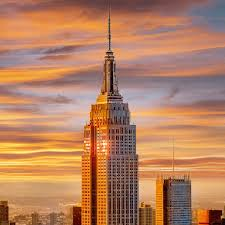

In [ ]:
# Read and display the image
image = cv.imread("/content/building.jpg")
cv2_imshow(image)

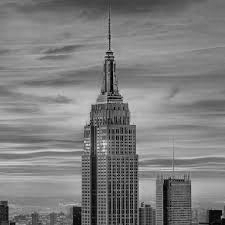

In [ ]:
# Convert the image to black and white
image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
cv2_imshow(image)

In [ ]:
# Initialize ToTensor()
trans = transforms.ToTensor()
imgT = trans(image)
imgT.shape

torch.Size([1, 225, 225])

### <font color ='pickle'>**Horizontal Edge Detection**

$$\mathbf{Kernel = }\begin{bmatrix}
-1 & -1 & -1 \\
0 & 0 & 0 \\
1 & 1 & 1 \\
\end{bmatrix}$$

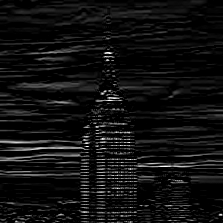

In [ ]:
# Create the horizontal edge detection filter
filter = torch.Tensor([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])

# Pass the filter and image to get output
out = convolution(imgT.view(225, 225), filter)

out = (out * 255).numpy()
# Display the output
cv2_imshow(out)

### <font color ='pickle'>**Vertical Edge Detection**

$$\mathbf{Kernel =}\begin{bmatrix}
-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1 \\
\end{bmatrix}$$

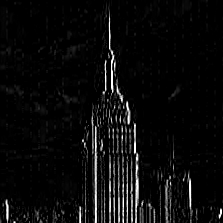

In [ ]:
# Create the vertical edge detection filter
filter = torch.Tensor([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])

# Pass the filter and image to get output
out = convolution(imgT.view(225, 225), filter)

out = (out * 255).numpy()
# Display the output
cv2_imshow(out)

## <font color ='pickle'>**Strides**

Strides define the movement of the filter map across the image. If the stride is more there will be less overlap between the image and filter and hence our resultant feature map would be smaller.

In the above examples we were considering stride as 1 and we were traversing over all the locations on the image.

Now for example, if the stride is 2, we will move forward and downward by skipping 2 pixels.

If the image and kernel are given by:

$$\mathbf{Image}=\begin{bmatrix}
1 & 1 & 1 & 0 & 0 \\
0 & 1 & 1 & 1 & 0 \\
0 & 0 & 1 & 1 & 1 \\
0 & 0 & 1 & 1 & 0 \\
0 & 1 & 1 & 0 & 0 \\
\end{bmatrix},\quad
\mathbf{Kernel}=\begin{bmatrix}
1 & 0 & 1 \\
0 & 1 & 0 \\
1 & 0 & 1 \\
\end{bmatrix}$$

<br>

Now if stride is 2, the output will be of size: $(\frac {5-3} {2} + 1, \frac {5-3} {2} + 1) = (2, 2)$

$$\mathbf{Output}=\begin{bmatrix}
4 & 4 \\
2 & 4 \\
\end{bmatrix}$$

Here, output is calculated as:

$O_{11} = (1*1 + 1*0 + 1*1) + (0*0 + 1*1 + 1*0) + (0*1 + 0*0 + 1*1) = 4$

$O_{12} = (1*1 + 0*0 + 0*1) + (1*0 + 1*1 + 0*0) + (1*1 + 1*0 + 1*1) = 4$

$O_{21} = (0*1 + 0*0 + 1*1) + (0*0 + 0*1 + 1*0) + (0*1 + 1*0 + 1*1) = 2$

$O_{22} = (1*1 + 1*0 + 1*1) + (1*0 + 1*1 + 0*0) + (1*1 + 0*0 + 0*1) = 4$


<br>

Now when we specify a stride of s and the size of image is $(x, y)$ and the size of kernel is $(m, n)$, then the size of output feature map would be:

$$((\frac {x - m} {s} + 1), (\frac {y - n} {s} + 1))$$



## <font color ='pickle'>**Padding** - From scratch

The most common issue that we face during convolution operation is the loss of pixels. We have seen that the shape of output is different from the input. Since we used comparitively small filter, the loss of pixels is not much but when we would need to apply a lot of convolution layers, we might loose a lot of features.

Thus to solve this problem we add a padding to our image. Padding is basically the addition of zeros along the borders of the image. Padding is basically used to maintain the dimensionality.

For example if we have an image given as:

$$\mathbf{Image(Original)}=\begin{bmatrix}
 1 & 2 & 3 \\
 4 & 5 & 6 \\
 7 & 8 & 9 \\
\end{bmatrix}$$

<br>

$$\mathbf{Image (Padded)}=\begin{bmatrix}
0 & 0 & 0 & 0 & 0 \\
0 & 1 & 2 & 3 & 0 \\
0 & 4 & 5 & 6 & 0 \\
0 & 7 & 8 & 9 & 0 \\
0 & 0 & 0 & 0 & 0 \\
\end{bmatrix}$$

<br>

Now when we specify a padding of p along all sides with stride of s, the size of image as $(x, y)$ and the size of kernel as $(m, n)$, then the size of output feature map would be:

$$((\frac {x - m + 2p} {s} + 1), (\frac {y - n + 2p} {s} + 1))$$



Now we will create a function for convolution with strides and padding:

In [ ]:
def convolution2(image, kernel, stride = (1,1), padding = 0):
    """
    Function to perform convolution operation
    Input: image and kernel
    Output: feature map
    """

    # Find the shapes of kernel and image
    xk = kernel.shape[0]
    yk = kernel.shape[1]
    ximg = image.shape[0]
    yimg = image.shape[1]

    # Shape of Output Convolution
    xout = int((ximg - xk + 2*padding) / stride[0] + 1)
    yout = int((yimg - yk + 2*padding) / stride[1] + 1)

    # Add padding if it is more than zero
    if padding != 0:
        # Create an array of zeros
        imagePadded = torch.zeros((image.shape[0] + padding * 2, image.shape[1] + padding * 2))

        # Fill the inner part with pixel value from image
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image

        # Store padded image in image
        image = imagePadded

    output = torch.zeros(xout, yout)
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            output[i,j] = (kernel * image[i*stride[0]: i*stride[0] + xk, j*stride[1]: j*stride[1] + yk]).sum()
            print(image[i*stride[0]: i*stride[0] + xk, j*stride[1]: j*stride[1] + yk])
            print()
            
    return output, image

In [ ]:
# Let us create the tensors for example image and kernel
image = torch.Tensor([[1, 2, 3, 4], [2, 4, 1, 2], [3, 4, 2, 1], [1, 2, 4, 3]])
filter = torch.tensor([[1, 2], [2, 1]])
print(image.shape)
print(filter.shape)
print(image)

torch.Size([4, 4])
torch.Size([2, 2])
tensor([[1., 2., 3., 4.],
        [2., 4., 1., 2.],
        [3., 4., 2., 1.],
        [1., 2., 4., 3.]])


### <font color ='pickle'>**Strides = (3, 4)  & Padding = 1**

In [ ]:
# Get the output feature map 
output, imagePadded = convolution2(image, filter, stride = (3, 4) , padding = 1)

# Print the padded image and it's shape
print(imagePadded)
print(imagePadded.shape)

tensor([[0., 0.],
        [0., 1.]])

tensor([[0., 0.],
        [4., 0.]])

tensor([[0., 3.],
        [0., 1.]])

tensor([[1., 0.],
        [3., 0.]])

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 1., 2., 3., 4., 0.],
        [0., 2., 4., 1., 2., 0.],
        [0., 3., 4., 2., 1., 0.],
        [0., 1., 2., 4., 3., 0.],
        [0., 0., 0., 0., 0., 0.]])
torch.Size([6, 6])


In [ ]:
# Print output and it's shape
print(output)
print(output.shape)

tensor([[1., 8.],
        [7., 7.]])
torch.Size([2, 2])


### <font color ='pickle'>**Strides = (3, 4)  & Padding = 2**

In [ ]:
# Get the output feature map 
output, imagePadded = convolution2(image, filter, stride = (3, 4), padding = 2)

# Print the padded image and it's shape
print(imagePadded)
print(imagePadded.shape)

tensor([[0., 0.],
        [0., 0.]])

tensor([[0., 0.],
        [0., 0.]])

tensor([[0., 0.],
        [0., 0.]])

tensor([[1., 2.],
        [2., 1.]])

tensor([[0., 0.],
        [0., 0.]])

tensor([[0., 0.],
        [0., 0.]])

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 2., 3., 4., 0., 0.],
        [0., 0., 2., 4., 1., 2., 0., 0.],
        [0., 0., 3., 4., 2., 1., 0., 0.],
        [0., 0., 1., 2., 4., 3., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
torch.Size([8, 8])


In [ ]:
# Print output and it's shape
print(output)
print(output.shape)

tensor([[ 0.,  0.],
        [ 0., 10.],
        [ 0.,  0.]])
torch.Size([3, 2])


In [ ]:
# Print output and it's shape
print(output)
print(output.shape)

tensor([[ 0.,  0.],
        [ 0., 10.],
        [ 0.,  0.]])
torch.Size([3, 2])


## <font color ='pickle'>**Padding and Stridding using Conv2d** 

### <font color ='pickle'>**Strides = (3, 4) , Padding =1**

In [ ]:
# Create an input 2D tensor
input = torch.Tensor([[1, 2, 3, 4], [2, 4, 1, 2], [3, 4, 2, 1], [1, 2, 4, 3]])

# Reshape the tensor
input = input.reshape(1, 1, 4, 4) # (batch_size, input_channels, height, width)
input.shape

torch.Size([1, 1, 4, 4])

In [ ]:
# Create object of Conv2d
model = torch.nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size = (2, 2),padding=1, stride=(3, 4) , bias = False)
#model.weight.data = torch.tensor([[[1, 2], [2, 1]]]).view(1,1,2,2).float()

# Get the convolved output for the input
output = model(input)

# Print output and its shape
print(output)
print(output.shape) # (batch_size, output_channels, height, width)


tensor([[[[-0.4745,  0.8061],
          [ 0.3225,  0.1875]]]], grad_fn=<ConvolutionBackward0>)
torch.Size([1, 1, 2, 2])


In [ ]:
model.weight.data.shape

torch.Size([1, 1, 2, 2])

### <font color ='pickle'>**Strides = (3, 4) , Padding =2**

In [ ]:
# Create an input 2D tensor
input = torch.Tensor([[1, 2, 3, 4], [2, 4, 1, 2], [3, 4, 2, 1], [1, 2, 4, 3]])

# Reshape the tensor
input = input.reshape(1, 1, 4, 4) # (batch_size, input_channels, height, width)
input.shape

torch.Size([1, 1, 4, 4])

In [ ]:
model = torch.nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size = (2,2),padding=2, stride=(3,4) , bias = False)
model.weight.data = torch.tensor([[[1, 2], [2, 1]]]).view(1,1,2,2).float()

# Get the convolved output for the input
output = model(input)

# Print output and its shape
print(output)
print(output.shape)


tensor([[[[ 0.,  0.],
          [ 0., 10.],
          [ 0.,  0.]]]], grad_fn=<ConvolutionBackward0>)
torch.Size([1, 1, 3, 2])


In [ ]:
model.state_dict()

OrderedDict([('weight', tensor([[[[1., 2.],
                        [2., 1.]]]]))])

## <font color ='pickle'>**Multiple Inputs and Outputs**

### <font color ='pickle'>**2 Inputs and One Output**

In [ ]:
input = torch.arange(1,33).view(1,2,4,4).float()

In [ ]:
input

tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]],

         [[17., 18., 19., 20.],
          [21., 22., 23., 24.],
          [25., 26., 27., 28.],
          [29., 30., 31., 32.]]]])

In [ ]:
input.shape #(batch_size, channels, H, W)

torch.Size([1, 2, 4, 4])

In [ ]:
# Create object of Conv2d
model = torch.nn.Conv2d(in_channels = 2, out_channels = 1, kernel_size = (2,2), padding=1, stride= 2)

# Get the convolved output for the input
output = model(input)

# Print output and its shape
print(output)
print(output.shape) # (batch_size, output_channels, H, W)

tensor([[[[ 0.3005,  1.7943,  1.8679],
          [ 3.5927, -0.3836, -4.2470],
          [ 4.1105, -3.9161, -8.4377]]]], grad_fn=<ConvolutionBackward0>)
torch.Size([1, 1, 3, 3])


In [ ]:
model.state_dict()

OrderedDict([('weight', tensor([[[[ 0.0255, -0.1259],
                        [-0.0255, -0.0136]],
              
                       [[-0.2837,  0.1901],
                        [ 0.0868,  0.0047]]]])), ('bias', tensor([0.2337]))])

In [ ]:
model.weight.shape

torch.Size([1, 2, 2, 2])

In [ ]:
model.bias.shape

torch.Size([1])

### <font color ='pickle'>**2 Inputs and 3 Outputs**

In [ ]:
# Create object of Conv2d
model = torch.nn.Conv2d(in_channels = 2, out_channels = 3, kernel_size = (2,2), padding=1, stride= 2)

# Get the convolved output for the input
output = model(input)

# Print output and its shape
print(output)
print(output.shape)

tensor([[[[-5.8070, -6.0826, -0.2269],
          [-6.8790, -9.5873, -2.8503],
          [ 0.0823, -3.0979, -3.6856]],

         [[ 4.1491,  4.6509,  1.1861],
          [ 7.0486,  7.7745,  1.7230],
          [ 3.7856,  3.9898,  0.7103]],

         [[ 4.6276,  3.5830, -1.8094],
          [ 5.7541,  2.9086, -4.0654],
          [ 2.8499,  3.9424,  0.6146]]]], grad_fn=<ConvolutionBackward0>)
torch.Size([1, 3, 3, 3])


In [ ]:
model.state_dict()

OrderedDict([('weight', tensor([[[[ 0.2914,  0.2211],
                        [ 0.1617,  0.2923]],
              
                       [[-0.2510, -0.0854],
                        [-0.0280, -0.3403]]],
              
              
                      [[[ 0.3396, -0.1710],
                        [ 0.1735, -0.3079]],
              
                       [[-0.1536,  0.2006],
                        [ 0.0149,  0.2508]]],
              
              
                      [[[ 0.0078,  0.2761],
                        [-0.3107, -0.2554]],
              
                       [[ 0.0160, -0.0247],
                        [-0.0272,  0.2886]]]])),
             ('bias', tensor([-0.3147,  0.1932, -0.0228]))])

In [ ]:
model.weight.shape

torch.Size([3, 2, 2, 2])

In [ ]:
model.bias.shape

torch.Size([3])

##<font color ='pickle'>**Pooling**

Convolution layers are very helpful as when they are stacked in deep learning models, layers close to input helps to identify low level features such as lines, edges etc. and layers that are present deep in the network helps to identify features like shapes and specific objects.

<br> 

But the feature map that we get as output is dependent on the position of features in the input and if the image changes even a little bit it will give as a different feature map.

<br>

This problem can be solved by down sampling. In this, we create a lower resolution version of the image. This image would still contain the important structural features like shapes, edges etc without excess detail which may not be useful.

We can achieve down sampling by introducing a pooling layer in our neural network model.

<br>

### <font color ='pickle'>**Pooling Operation**

Pooling operation is much like a filter to be applied to feature maps. The size of the pooling operation or filter is smaller than the size of the feature map. It is almost always 2 × 2 pixels applied with a stride of 2 pixels. This means that the pooling layer will always reduce the size of each feature map by a factor of 2.

For example: A pooling layer applied to a feature map of $(6, 6)$ will result in an output pooled feature map of $(\frac {6-2} {2} +1, \frac {6-2} {2} +1) = (3, 3)$


## <font color ='pickle'>**Types of Pooling**

### <font color ='pickle'>**1) Max Pooling**

For each batch of feature map, the maximum element is selected in max pooling.

For example if the input is:

$$\mathbf{Input} = \begin{bmatrix}
 1 & 2 & 3 & 1\\
 4 & 5 & 6 & 2\\
 6 & 8 & 9 & 5\\
 2 & 4 & 10 & 8\\
\end{bmatrix}$$

Then after applying max pooling with pool_size = (2, 2) and stride 2, we will get the output as:

$$\mathbf{Output} = \begin{bmatrix}
 5 & 6 \\
 8 & 10 \\
\end{bmatrix}$$

Outputs are calculated as:

$O_{11} = max(1, 2, 4, 5) = 5$

$O_{12} = max(3, 1, 6, 2) = 6$

$O_{21} = max(6, 8, 2, 4) = 8$

$O_{22} = max(2, 4, 10, 8) = 10$



We will use the `MaxPool2d` function from `torch.nn` library. It takes input feature map with shape: `(batch_size, input_channels, height, width)`. It takes in the 2 main parameters:

- `kernel_size` : The size of the window to take a max over.

- `stride` : The stride of the window. Default value is kernel_size.


In [ ]:
def pooling(image, kernel, mode = 'max', stride = (1,1) , padding = 0):
    """
    Function to perform convolution operation
    Input: image and kernel
    Output: feature map
    """

    # Find the shapes of kernel and image
    xk = kernel[0]
    yk = kernel[1]
    ximg = image.shape[0]
    yimg = image.shape[1]

    # Shape of Output Convolution
    xout = int((ximg - xk + 2*padding) / stride[0] + 1)
    yout = int((yimg - yk + 2*padding) / stride[1] + 1)

    # Add padding if it is more than zero
    if padding != 0:
        # Create an array of zeros
        imagePadded = torch.zeros((image.shape[0] + padding * 2, image.shape[1] + padding * 2))

        # Fill the inner part with pixel value from image
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image

        # Store padded image in image
        image = imagePadded

    output = torch.zeros(xout, yout)
    for i in range(0,output.shape[0]):

        for j in range(0,output.shape[1]):
            if mode == 'max':
              output[i, j] = (image[i*stride[0]: i*stride[0] + xk, j*stride[1]: j*stride[1] + yk]).max()
            elif mode == 'average':
              output[i, j] = (image[i*stride[0]: i*stride[0] + xk, j*stride[1]: j*stride[1] + yk]).mean()
    return output, image

In [ ]:
# Create an example tensor
image = torch.Tensor([[1, 2, 3, 1], [4, 5, 6, 2], [6, 8, 9, 5], [2, 4, 10, 8]])
output, image = pooling(image, kernel = (2,2), mode = 'average', stride = (2, 2) , padding = 0)
print(image)
print(output)
print(output.shape)


tensor([[ 1.,  2.,  3.,  1.],
        [ 4.,  5.,  6.,  2.],
        [ 6.,  8.,  9.,  5.],
        [ 2.,  4., 10.,  8.]])
tensor([[3., 3.],
        [5., 8.]])
torch.Size([2, 2])


In [ ]:
# Get the output from the pooling layer
# Create an object for pooling
pool = torch.nn.MaxPool2d(kernel_size = (2, 2), stride = (2,2))
image = image.reshape(1, 1, 4, 4)
print(image)
output = pool(image)

# Print output and it's shape
print(output)
print(output.shape)

tensor([[[[ 1.,  2.,  3.,  1.],
          [ 4.,  5.,  6.,  2.],
          [ 6.,  8.,  9.,  5.],
          [ 2.,  4., 10.,  8.]]]])
tensor([[[[ 5.,  6.],
          [ 8., 10.]]]])
torch.Size([1, 1, 2, 2])


### <font color ='pickle'>**2) Average Pooling**

For each batch of feature map, the average of all element is selected in average pooling.

For example if the input is:

$$\mathbf{Input} = \begin{bmatrix}
 1 & 2 & 3 & 1\\
 4 & 5 & 6 & 2\\
 6 & 8 & 9 & 5\\
 2 & 4 & 10 & 8\\
\end{bmatrix}$$

Then after applying average pooling with pool_size = (2, 2) and stride 2, we will get the output as:

$$\mathbf{Output} = \begin{bmatrix}
 3 & 3 \\
 5 & 8 \\
\end{bmatrix}$$

Outputs are calculated as:

$O_{11} = \frac {1+2+4+5} {4} = 3$

$O_{12} = \frac {3+1+6+2} {4} = 3$

$O_{21} = \frac {6+8+2+4} {4} = 5$

$O_{22} = \frac {9+5+10+8} {4} = 8$

We will use the `AvgPool2d` function from `torch.nn` library. It takes input feature map with shape: `(batch_size, input_channels, height, width)`. It takes in the 2 main parameters:

- `kernel_size` : The size of the window to take a max over.

- `stride` : The stride of the window. Default value is kernel_size.

In [ ]:
# Create an object for pooling
pool = torch.nn.AvgPool2d(kernel_size = (2, 2), stride = 2)

# Create an example tensor
input = torch.Tensor([[1, 2, 3, 1], [4, 5, 6, 2], [6, 8, 9, 5], [2, 4, 10, 8]])
input = input.reshape(1, 1, 4, 4)

In [ ]:
# Get the output from the pooling layer
output = pool(input)

# Print output and it's shape
print(output)
print(output.shape)

tensor([[[[3., 3.],
          [5., 8.]]]])
torch.Size([1, 1, 2, 2])


## <font color ='pickle'>**1x1 Convolutions**

We can use pooling layers to down sample the feature maps. But very often in deep neural networks, the number of channels increases and we get a very large number of parameters. Now pooling can only be used to decrase the size of the image.

<br>

In order to address this problem, we can use `1x1 Convolutions`. This offers channel-wise pooling often known as channel wise pooling or projection layer.

- We can directly apply a 1x1 filter on our input without the need for padding.
- It will always have a stride of 1. 
- It will result in a feature map with same width and height.

<br>

For example, let us take and input image of size (6, 6, 192). Now we need to down sample the channels, thus we will use a 1x1 filter.

The filter will be of shape (1, 1) and we have to specify the new number of channels that we require. That is if we want to reduce the number of channels from 192 to 64, we will use the Conv2d layer as:

`Conv2d(in_channels = 192, out_channels = 64, kernel_size = (1,1))`

In [ ]:
# Create an input with batch size = 1, number of channels = 192, height = 6 and width = 6
input = torch.randn((1, 192, 6, 6))

# Create a layer for 1x1 convolution which will reduce the number of channels from 192 to 64
layer = torch.nn.Conv2d(in_channels = 192, out_channels = 64, kernel_size = (1,1))

# Get the output from 1x1 convolution and print it's shape
output = layer(input)
print(output.shape)

torch.Size([1, 64, 6, 6])


We can observe that using 1x1 convolution we are able to reduce the number of channels in the feature map without effecting its dimensions.

## <font color ='pickle'>**Batch Normalization 2D**

Batch normalization is done to scale the outputs of the deep learning model by standardizing the activations of each input variable per mini-batch. 

It is very important while using a very dense neural network as it reparametrizes the inputs for the next layer by scaling / standardizing it.

We can use the `BatchNNorm2d` function from the torch.nn library. The mean and standard deviation are calculated per-dimension over the mini-batches. It takes input of the shape: `(batch_size, input_channels, height, width)`.

Let us see an example for this:

In [2]:
# Create an input tensor of batch size = 3, number of channels = 2, height = 3 and width = 3
import torch
x = torch.Tensor([
                    [
                      [[1, 1, -2], [1, -2, 1], [-2, 1, 1]], 
                      [[1, 2, 1], [2, 1, 1], [1, 1, 2]]
                      ],
                  
                    [
                      [[-1, -2, 2], [2, -2, 2], [-1, 0, 0]], 
                      [[1, 2, 1], [1, 1, 1], [2, 1, 2]]
                      ],
                  
                    [
                      [[-2, 1, 2], [-2, 0, 2], [-1, -1, 1]], 
                      [[1, 2, 1], [1, 2, 1], [1, 1, 2]]
                      ],
                  
                  ])
print(x.shape)
print()
print(x)

torch.Size([3, 2, 3, 3])

tensor([[[[ 1.,  1., -2.],
          [ 1., -2.,  1.],
          [-2.,  1.,  1.]],

         [[ 1.,  2.,  1.],
          [ 2.,  1.,  1.],
          [ 1.,  1.,  2.]]],


        [[[-1., -2.,  2.],
          [ 2., -2.,  2.],
          [-1.,  0.,  0.]],

         [[ 1.,  2.,  1.],
          [ 1.,  1.,  1.],
          [ 2.,  1.,  2.]]],


        [[[-2.,  1.,  2.],
          [-2.,  0.,  2.],
          [-1., -1.,  1.]],

         [[ 1.,  2.,  1.],
          [ 1.,  2.,  1.],
          [ 1.,  1.,  2.]]]])


In [3]:
# Create the object for batch normalization and pass the batch size to it
batchnorm = torch.nn.BatchNorm2d(num_features=2, affine = True)

In [ ]:
output = batchnorm(x)

In [ ]:
batchnorm.state_dict()

OrderedDict([('weight', tensor([1., 1.])),
             ('bias', tensor([0., 0.])),
             ('running_mean', tensor([0.0000, 0.1333])),
             ('running_var', tensor([1.1308, 0.9231])),
             ('num_batches_tracked', tensor(1))])

In [ ]:
print(output)
print(output.shape)

tensor([[[[ 0.6708,  0.6708, -1.3416],
          [ 0.6708, -1.3416,  0.6708],
          [-1.3416,  0.6708,  0.6708]],

         [[-0.7071,  1.4142, -0.7071],
          [ 1.4142, -0.7071, -0.7071],
          [-0.7071, -0.7071,  1.4142]]],


        [[[-0.6708, -1.3416,  1.3416],
          [ 1.3416, -1.3416,  1.3416],
          [-0.6708,  0.0000,  0.0000]],

         [[-0.7071,  1.4142, -0.7071],
          [-0.7071, -0.7071, -0.7071],
          [ 1.4142, -0.7071,  1.4142]]],


        [[[-1.3416,  0.6708,  1.3416],
          [-1.3416,  0.0000,  1.3416],
          [-0.6708, -0.6708,  0.6708]],

         [[-0.7071,  1.4142, -0.7071],
          [-0.7071,  1.4142, -0.7071],
          [-0.7071, -0.7071,  1.4142]]]], grad_fn=<NativeBatchNormBackward0>)
torch.Size([3, 2, 3, 3])


We can observe that the first channel of from both the batches have similar elements, thus they were scaled together. Also the second channel of both batches have similar elements, thus they were scaled together.

This shows that the normalization occured per dimension in the mini batches.

In [ ]:
x_mean = torch.mean(x, dim=(0,2,3), keepdim=True)

In [ ]:
x_mean

tensor([[[[0.0000]],

         [[1.3333]]]])

In [ ]:
x_var = torch.var(x, dim=(0,2,3), unbiased=False,keepdim=True)
x_sigma = torch.sqrt(x_var + 1e-5)

In [ ]:
z = (x-x_mean)/x_sigma

In [ ]:
z

tensor([[[[ 0.6708,  0.6708, -1.3416],
          [ 0.6708, -1.3416,  0.6708],
          [-1.3416,  0.6708,  0.6708]],

         [[-0.7071,  1.4142, -0.7071],
          [ 1.4142, -0.7071, -0.7071],
          [-0.7071, -0.7071,  1.4142]]],


        [[[-0.6708, -1.3416,  1.3416],
          [ 1.3416, -1.3416,  1.3416],
          [-0.6708,  0.0000,  0.0000]],

         [[-0.7071,  1.4142, -0.7071],
          [-0.7071, -0.7071, -0.7071],
          [ 1.4142, -0.7071,  1.4142]]],


        [[[-1.3416,  0.6708,  1.3416],
          [-1.3416,  0.0000,  1.3416],
          [-0.6708, -0.6708,  0.6708]],

         [[-0.7071,  1.4142, -0.7071],
          [-0.7071,  1.4142, -0.7071],
          [-0.7071, -0.7071,  1.4142]]]])

In [ ]:
z/(output + 1e-5)

tensor([[[[1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000]]],


        [[[1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000],
          [1.0000, 0.0000, 0.0000]],

         [[1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000]]],


        [[[1.0000, 1.0000, 1.0000],
          [1.0000, 0.0000, 1.0000],
          [1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000]]]], grad_fn=<DivBackward0>)

## <font color ='pickle'>**Dropouts 2D**

This layer will randomly zero out the entire channel with a probability p. The size will remain the same.

For example if we have a feature map of (number of channels, height, width) = (3, 4, 4), Any of the 3 channels with size (4, 4) can have all of its elements become zero with a probability of p when it passes through this layer.

Let us see a small example to understand this:

In [ ]:
# Create an input with batch size = 1, number of channels = 3, height = 3 and width = 3
input = torch.randn(1, 3, 3, 3)
print(input)
print()
# Create a 2D Dropout layer
dropout = torch.nn.Dropout2d(p = 0.5)

# Get the output after applying dropouts and print it
output = dropout(input)
print(output, sep='\n')
print(output.shape)

tensor([[[[-0.6049,  0.4673, -1.7072],
          [ 0.3731, -2.2556,  2.0247],
          [-0.3461, -0.2205, -0.5924]],

         [[ 0.9314, -2.1677, -0.7595],
          [-1.1075,  0.1383,  0.3182],
          [ 2.3520, -0.4324,  0.2496]],

         [[-0.3666,  2.4223,  1.6656],
          [-0.8131,  0.5632,  0.9658],
          [ 0.1497,  1.4766,  2.7006]]]])

tensor([[[[-0.0000,  0.0000, -0.0000],
          [ 0.0000, -0.0000,  0.0000],
          [-0.0000, -0.0000, -0.0000]],

         [[ 0.0000, -0.0000, -0.0000],
          [-0.0000,  0.0000,  0.0000],
          [ 0.0000, -0.0000,  0.0000]],

         [[-0.7332,  4.8447,  3.3313],
          [-1.6261,  1.1264,  1.9316],
          [ 0.2994,  2.9533,  5.4011]]]])
torch.Size([1, 3, 3, 3])


## <font color ='pickle'>**1D Convolution**

torch.nn provides us with `Conv1d()` function which applies a 1D convolution over an input signal composed of several input planes.

It takes input image with shape: `(batch_size, input_channels, signal_length)`.

<br>

It takes in the following parameters:

- `in_channels` : Number of channels in the input image.
- `out_channels` : Number of channels produced by the convolution.
- `kernel_size` : Size of the kernel.
- `stride` : Stride of the convolution. Default: 1.
- `padding` : Padding added to both sides of the input. Default: 0.



<font color ='pickle'>**Conv1D - Input1D**

Let us consider a 1D tensor of size 10. 

Now before applying the convolution operation we have to change it's shape to (batch_size, input_channels, signal_length) format.

Here we would consider batch_size = 1, input_channels = 1 and signal_length = 10.

In [ ]:
# Create an input 1D tensor
input = torch.Tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Reshape the tensor
input = input.reshape(1, 1, 10)
input.shape

torch.Size([1, 1, 10])

Now, we will define the convolution operation with input and output channel as 1 and kernel size of 3.

After convolution, we will get an output of shape:(1, 1, (10 - 3 + 1)) = (1, 1, 8)

In [ ]:
# Create object of Conv1d
conv = torch.nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 3)

# Get the convolved output for the input
output = conv(input)

# Print output and its shape
print(output)
print(output.shape)

tensor([[[ 0.0592, -0.0624, -0.1840, -0.3056, -0.4272, -0.5488, -0.6704,
          -0.7920]]], grad_fn=<ConvolutionBackward0>)
torch.Size([1, 1, 8])


<font color ='pickle'>**Conv1D - Input2D**

Let us consider a 2D tensor of shape (2, 4). 

Now before applying the convolution operation we have to change it's shape to (batch_size, input_channels, signal_length) format.

Here we would consider batch_size = 1, input_channels = 2 and signal_length = 4.

In [ ]:
# Create an input 2D tensor
input = torch.Tensor([[1, 2, 3, 4], [2, 4, 1, 2]])

# Reshape the tensor
input = input.reshape(1, 2, 4)
input.shape

torch.Size([1, 2, 4])

Now, we will define the convolution operation with input channel as 2, output channel as 1 and kernel size of 2.

After convolution, we will get an output of shape:(1, 1, (4 - 3 + 1)) = (1, 1, 3)

In [ ]:
# Create object of Conv1d
conv = torch.nn.Conv1d(in_channels = 2, out_channels = 1, kernel_size = 2)

# Get the convolved output for the input
output = conv(input)

# Print output and its shape
print(output)
print(output.shape)

tensor([[[3.2133, 3.9813, 3.7867]]], grad_fn=<ConvolutionBackward0>)
torch.Size([1, 1, 3])
